In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
import wandb

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ttc4900/7allV03.csv


In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
my_secret = user_secrets.get_secret("wandb_api_key") 
wandb.login(key=my_secret)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 1pravin-borate (data-winners). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
data = pd.read_csv("/kaggle/input/ttc4900/7allV03.csv")
data.head()

,category,text
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...


In [4]:
data = data.sample(frac=0.5,random_state=42)

In [5]:
data.shape

(2450, 2)

In [6]:
data['category'].value_counts()

category
siyaset       373
kultur        363
ekonomi       357
teknoloji     345
spor          345
dunya         340
saglik        327
Name: count, dtype: int64

In [7]:
import torch
from transformers import pipeline, BertForSequenceClassification,BertTokenizer,BertConfig
from torch.utils.data import Dataset

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [9]:
labels = data['category'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['teknoloji', 'spor', 'dunya', 'kultur', 'ekonomi', 'saglik', 'siyaset']

In [10]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}
label2id={label:id for id,label in enumerate(labels)}

In [11]:
label2id

{'teknoloji': 0,
 'spor': 1,
 'dunya': 2,
 'kultur': 3,
 'ekonomi': 4,
 'saglik': 5,
 'siyaset': 6}

In [12]:
data.rename(columns={'category':'label_name'},inplace=True)

In [13]:
data['label_name'] = data['label_name'].str.strip()

In [14]:
data['label'] = data['label_name'].map(label2id)

In [15]:
data.head()

,label_name,text,label
4657,teknoloji,acıların kedisi sam çatık kaşlı kedi sam in i...,0
3539,spor,g saray a git santos van_persie den forma ala...,1
907,dunya,endonezya da çatışmalar 14 ölü endonezya da i...,2
4353,teknoloji,emniyetten polis logolu virüs uyarısı telefon...,0
3745,spor,beni türk yapın cristian_baroni yıldırım dan ...,1


In [16]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(data,test_size=0.3,random_state=42,stratify=data['label_name'])
test,validation = train_test_split(test,test_size=1/3,random_state=42,stratify=test['label_name'])
print(f"Training data shape : {train.shape}")
print(f"Testing data shape : {test.shape}")
print(f"Validation data shape : {validation.shape}")

Training data shape : (1715, 3)
Testing data shape : (490, 3)
Validation data shape : (245, 3)


In [17]:
from datasets import Dataset,DatasetDict

dataset = DatasetDict(
    {
        'train':Dataset.from_pandas(train,preserve_index=False),
        'test':Dataset.from_pandas(test,preserve_index=False),
        'validation':Dataset.from_pandas(validation,preserve_index=False)
    }
)

In [18]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label_name', 'text', 'label'],
        num_rows: 1715
    })
    test: Dataset({
        features: ['label_name', 'text', 'label'],
        num_rows: 490
    })
    validation: Dataset({
        features: ['label_name', 'text', 'label'],
        num_rows: 245
    })
})

In [21]:
model_ckpt = "dbmdz/bert-base-turkish-uncased"

tokenizer = BertTokenizer.from_pretrained(model_ckpt,max_length=512)

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [22]:
def tokenize(batch):
    temp = tokenizer(batch['text'],padding=True,truncation=True)
    return temp

In [23]:
encoded_embeddings = dataset.map(tokenize,batched=True,batch_size=None)

Map:   0%|          | 0/1715 [00:00<?, ? examples/s]

Map:   0%|          | 0/490 [00:00<?, ? examples/s]

Map:   0%|          | 0/245 [00:00<?, ? examples/s]

In [24]:
config = BertConfig.from_pretrained(model_ckpt,label2id=label2id,id2label=id2label)
config

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "teknoloji",
    "1": "spor",
    "2": "dunya",
    "3": "kultur",
    "4": "ekonomi",
    "5": "saglik",
    "6": "siyaset"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "dunya": 2,
    "ekonomi": 4,
    "kultur": 3,
    "saglik": 5,
    "siyaset": 6,
    "spor": 1,
    "teknoloji": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

In [25]:
model = BertForSequenceClassification.from_pretrained(
    model_ckpt,
    config=config
).to(device)

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [27]:
from transformers import TrainingArguments

In [28]:
from transformers import TrainingArguments

batch_size = 16
training_dir = 'turkish_bert_base_train_dir'

training_args = TrainingArguments(
    output_dir=training_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_gpu_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',
    disable_tqdm=False
)

In [32]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1,"Precision":precision,"Recall":recall}

In [33]:
from transformers import Trainer

trainer = Trainer(model=model,
                 args=training_args,
                 compute_metrics=compute_metrics,
                 train_dataset=encoded_embeddings['train'],
                 eval_dataset=encoded_embeddings['validation'],
                 tokenizer=tokenizer)

<ipython-input-33-99f1323e77d7>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,


In [34]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.314947,0.902041,0.902724,0.904855,0.902021
2,No log,0.349891,0.914286,0.915398,0.917677,0.914520


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


TrainOutput(global_step=216, training_loss=0.15117904875013563, metrics={'train_runtime': 198.586, 'train_samples_per_second': 17.272, 'train_steps_per_second': 1.088, 'total_flos': 902511434496000.0, 'train_loss': 0.15117904875013563, 'epoch': 2.0})

In [35]:
preds_output = trainer.predict(encoded_embeddings['test'])
preds_output.metrics

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


{'test_loss': 0.2877015471458435,
 'test_accuracy': 0.9244897959183673,
 'test_f1': 0.9245059717166101,
 'test_Precision': 0.9267675181960897,
 'test_Recall': 0.9247769363669615,
 'test_runtime': 7.9797,
 'test_samples_per_second': 61.406,
 'test_steps_per_second': 3.885}

In [36]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = encoded_embeddings['test'][:]['label']

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        69
           1       1.00      0.96      0.98        69
           2       0.82      0.94      0.88        68
           3       0.96      0.99      0.97        73
           4       0.90      0.80      0.85        71
           5       0.95      0.97      0.96        65
           6       0.91      0.93      0.92        75

    accuracy                           0.92       490
   macro avg       0.93      0.92      0.92       490
weighted avg       0.93      0.92      0.92       490



In [38]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

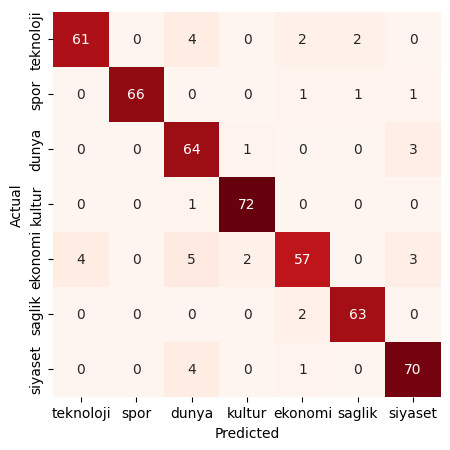

In [39]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [40]:
text = "Makine öğrenimi kendisi de daha da otomatik hale doğru ilerliyor."

def get_prediction(text):
    input_encoded = tokenizer(text, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**input_encoded)

    logits = outputs.logits

    pred = torch.argmax(logits, dim=1).item()
    return id2label[pred]

get_prediction(text)

'teknoloji'

In [41]:
model_path = "turkish-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('turkish-text-classification-model/tokenizer_config.json',
 'turkish-text-classification-model/special_tokens_map.json',
 'turkish-text-classification-model/vocab.txt',
 'turkish-text-classification-model/added_tokens.json')

In [43]:
model_path = "turkish-text-classification-model"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizer.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [47]:
nlp("Bugün hava çok güzel, dışarıda yürümek istiyorum.")

[{'label': 'saglik', 'score': 0.3078027665615082}]

In [45]:
nlp("Derin Öğrenme ve Yapay Zeka dünyayı değiştirecek.")

[{'label': 'teknoloji', 'score': 0.9017266631126404}]

In [46]:
nlp("Son zamanlarda ekonomideki oynaklık nedeniyle, borsa endeksi oldukça düşük seviyelerde seyrediyor.")

[{'label': 'ekonomi', 'score': 0.9458724856376648}]